In [11]:
## Loading package
# 过滤掉所有警告
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'
from utils import mclust_R, generate_noise
from model import DCCAE
from preprocess import preprocessing, clr_normalize_each_cell
from preprocess import fix_seed
import numpy as np

adata_modality_1 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/adata_ADT.h5ad")

In [11]:
noise_level = 3

mean_1 = adata_modality_1.X.mean()
std_1 = [5, 10, 20]

mean_2 = adata_modality_2.X.mean()
std_2 = [500, 1000, 2000]


sc.pp.filter_genes(adata_modality_1, min_cells=10)
sc.pp.filter_cells(adata_modality_1, min_genes=80)
sc.pp.filter_genes(adata_modality_2, min_cells=50)
adata_modality_2 = adata_modality_2[adata_modality_1.obs_names].copy()

adata_1_noised = adata_modality_1.copy()
adata_2_noised = adata_modality_2.copy()

adata_1_noised.X = generate_noise(adata_1_noised.X,mean=mean_1, std=std_1[noise_level-1], mode='gaussian', dropout_rate=0)
adata_2_noised.X = generate_noise(adata_2_noised.X, mean=mean_2, std=std_2[noise_level-1], mode='gaussian', dropout_rate=0)

from scipy.sparse import csr_matrix
adata_1_noised.X = csr_matrix(adata_1_noised.X)
adata_2_noised.X = csr_matrix(adata_2_noised.X)

# sc.pp.pca(adata_1_noised)
# sc.pp.pca(adata_2_noised)

1.874069991670597
-9.054038329929877


In [12]:
adata_1_noised.write_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/level_3_RNA.h5ad")
adata_2_noised.write_h5ad("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/level_3_ADT.h5ad")

In [66]:
adata_result = sc.read_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Thymus_noised.h5ad')

In [162]:
adata_1_noised = sc.read_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/level_3_RNA.h5ad')
adata_2_noised = sc.read_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/level_3_ADT.h5ad')

sc.pp.pca(adata_1_noised)
sc.pp.pca(adata_2_noised)

In [163]:
# n_output = 15, n_DCCAE = 10, epochs = 250

n_output = 15
features1 = adata_1_noised.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_2_noised.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_1_noised.obsm['X_pca'].copy()
Y = adata_2_noised.obsm['X_pca'].copy()

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCAE = 10
epochs = 100
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCAE, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs, learning_rate=0.001)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_1_noised.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_2_noised.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_1_noised.obsm["DCCAE"] = np.concatenate((adata_1_noised.obsm["DCCAE_X"], adata_2_noised.obsm["DCCAE_Y"]),axis=1)

Training Progress: 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]

model training finished!


In [164]:
mclust_R(adata=adata_1_noised, used_obsm="DCCAE_X", num_cluster=7)

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4183 × 14861
    obs: 'orig.ident', 'x', 'y', 'n_genes', 'clusters_mclust'
    var: 'n_cells'
    uns: 'INR', 'pca'
    obsm: 'spatial', 'X_pca', 'DCCAE_X', 'DCCAE'
    varm: 'PCs'

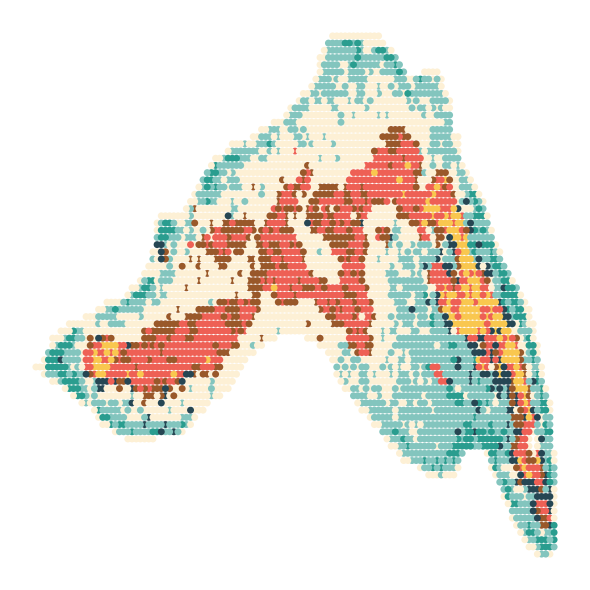

In [170]:
use_rep = 'SpaKnit_level_3'
adata_result.obs[use_rep] = adata_1_noised.obs['clusters_mclust']

mapping = {1: 1, 2: 5, 3: 2, 4: 4, 5: 7, 6: 3, 7: 6}

# 使用映射字典替换数字
adata_result.obs[use_rep] = adata_result.obs[use_rep].map(mapping)

# 将替换后的变量转换为类别型变量，并指定类别顺序
adata_result.obs[use_rep] = pd.Categorical(
    adata_result.obs[use_rep], 
    categories=[1, 2, 3, 4, 5, 6, 7], 
    ordered=True
)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
colors = [
    '#264653', '#2a9d8f', '#83c5be', '#fdf0d5', '#99582a', '#f9c74f', '#ee6055'
]
sc.pl.embedding(adata_result, basis='spatial', color=[use_rep], ax=ax, s=100, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.invert_yaxis()
for spine in ax.spines.values():
    spine.set_visible(False)
# remove legend
ax.get_legend().remove()
plt.tight_layout()

fig.savefig(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/noised_test/{use_rep}.png')
fig.savefig(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/noised_test/{use_rep}.eps')

In [171]:
adata_result

AnnData object with n_obs × n_vars = 4183 × 0
    obs: 'SpatialGlue_level_1', 'SpatialGlue_level_2', 'SpatialGlue_level_3', 'SpaKnit_level_1', 'SpaKnit_level_2', 'SpaKnit_level_3'
    uns: 'SpatialGlue_level_1_colors', 'SpatialGlue_level_2_colors', 'SpatialGlue_level_3_colors', 'SpaKnit_level_1_colors', 'SpaKnit_level_2_colors', 'SpaKnit_level_3_colors'
    obsm: 'spatial'

## SpatialGlue

In [53]:
## spatialglue
data_type = 'Stereo-CITE-seq'
from SpatialGlue.preprocess import construct_neighbor_graph
adata_1_noised.obsm['feat'] = adata_1_noised.obsm['X_pca']
adata_2_noised.obsm['feat'] = adata_2_noised.obsm['X_pca']
data = construct_neighbor_graph(adata_1_noised, adata_2_noised, datatype=data_type)

# define model
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, datatype=data_type)

# train model
output = model.train()

adata = adata_1_noised.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata.obsm['SpatialGlue'] = output['SpatialGlue']
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=7, method=tool, use_pca=True)

100%|██████████| 1500/1500 [02:09<00:00, 11.55it/s]


Model training finished!

fitting ...
  |======================================================================| 100%


In [57]:
use_rep = 'SpatialGlue_level_3'

obs_df = adata.obs[['SpatialGlue']].copy()

# # 创建新的 AnnData 对象
# adata_result = anndata.AnnData(obs=obs_df)
adata_result.obs[use_rep] = adata.obs['SpatialGlue']
# # 重命名列
# adata_result.obs.rename(columns={'SpatialGlue': use_rep}, inplace=True)

# adata_result.obsm['spatial'] = adata_1_noised.obsm['spatial']

In [58]:
adata_result

AnnData object with n_obs × n_vars = 4183 × 0
    obs: 'SpatialGlue_level_1', 'SpatialGlue_level_2', 'SpatialGlue_level_3'
    uns: 'SpatialGlue_level_1_colors', 'SpatialGlue_level_2_colors', 'SpatialGlue_level_3_colors'
    obsm: 'spatial'

In [60]:
mapping = {1: 1, 2: 5, 3: 3, 4: 4, 5: 2, 6: 6, 7: 7}

# 使用映射字典替换数字
adata_result.obs[use_rep] = adata_result.obs[use_rep].map(mapping)

# 将替换后的变量转换为类别型变量，并指定类别顺序
adata_result.obs[use_rep] = pd.Categorical(
    adata_result.obs[use_rep], 
    categories=[1, 2, 3, 4, 5, 6, 7], 
    ordered=True
)

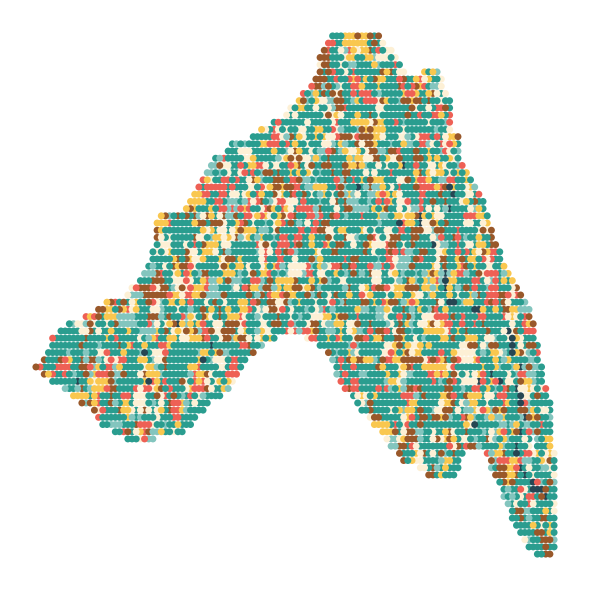

In [61]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
colors = [
    '#264653', '#2a9d8f', '#83c5be', '#fdf0d5', '#99582a', '#f9c74f', '#ee6055'
]
sc.pl.embedding(adata_result, basis='spatial', color=use_rep, ax=ax, s=100, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.invert_yaxis()
for spine in ax.spines.values():
    spine.set_visible(False)
# remove legend
ax.get_legend().remove()
plt.tight_layout()

fig.savefig(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/noised_test/{use_rep}.png')
fig.savefig(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/noised_test/{use_rep}.eps')

In [25]:
adata_result.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Thymus_noised.h5ad')

In [26]:
import scanpy as sc
adata_result = sc.read_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Thymus_noised.h5ad')

e:\anaconda\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## MultiMAP

In [9]:
import MultiMAP
import numpy as np
import anndata

In [18]:
adata_1_noised = sc.read_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/level_3_RNA.h5ad')
adata_2_noised = sc.read_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/data/Mouse_Thymus_1/Noised/level_3_ADT.h5ad')

sc.pp.pca(adata_1_noised)
sc.pp.pca(adata_2_noised)

adata = MultiMAP.Integration([adata_1_noised, adata_2_noised], ['X_pca', 'X_pca'])
mid_index = adata.shape[0] // 2
adata1 = adata[:mid_index]
adata2 = adata[mid_index:]
combined_X_multimap = np.concatenate((adata1.obsm['X_multimap'], adata2.obsm['X_multimap']), axis=1)
adata = anndata.AnnData(obs=adata1.obs, obsm={'X_multimap': combined_X_multimap})
mclust_R(adata, used_obsm='X_multimap', num_cluster=7)

e:\anaconda\Lib\site-packages\MultiMAP\__init__.py:63: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = flagged[ind1].concatenate(flagged[ind2], join='inner')
e:\anaconda\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


fitting ...
  |                                                                      |   0%

e:\anaconda\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
e:\anaconda\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
e:\anaconda\Lib\site-packages\rpy2\robjects\numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4183 × 0
    obs: 'orig.ident', 'x', 'y', 'n_genes', 'clusters_mclust'
    obsm: 'X_multimap'

e:\anaconda\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
e:\anaconda\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
e:\anaconda\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


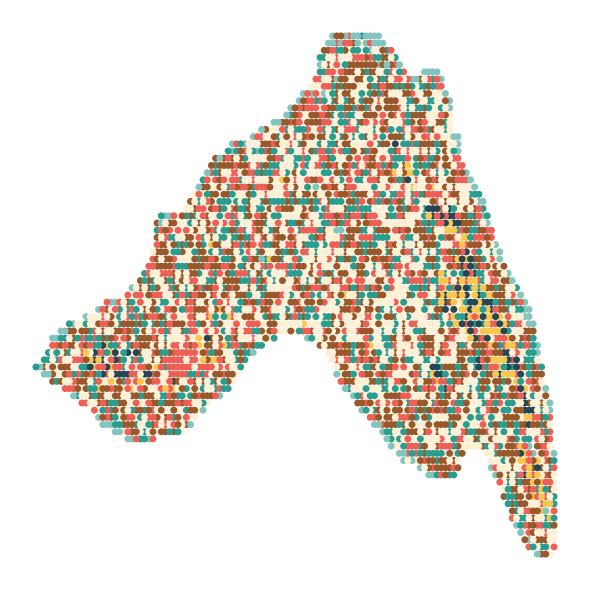

In [23]:
use_rep = 'MultiMAP_level_3'
adata_result.obs[use_rep] = adata.obs['clusters_mclust']

mapping = {1: 4, 2: 6, 3: 3, 4: 7, 5: 5, 6: 2, 7: 1}

# 使用映射字典替换数字
adata_result.obs[use_rep] = adata_result.obs[use_rep].map(mapping)

# 将替换后的变量转换为类别型变量，并指定类别顺序
adata_result.obs[use_rep] = pd.Categorical(
    adata_result.obs[use_rep], 
    categories=[1, 2, 3, 4, 5, 6, 7], 
    ordered=True
)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
colors = [
    '#264653', '#2a9d8f', '#83c5be', '#fdf0d5', '#99582a', '#f9c74f', '#ee6055'
]
sc.pl.embedding(adata_result, basis='spatial', color=[use_rep], ax=ax, s=100, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.invert_yaxis()
for spine in ax.spines.values():
    spine.set_visible(False)
# remove legend
ax.get_legend().remove()
plt.tight_layout()

fig.savefig(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/noised_test/{use_rep}.png')
fig.savefig(f'D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/noised_test/{use_rep}.eps')

In [24]:
adata_result

AnnData object with n_obs × n_vars = 4183 × 0
    obs: 'SpatialGlue_level_1', 'SpatialGlue_level_2', 'SpatialGlue_level_3', 'SpaKnit_level_1', 'SpaKnit_level_2', 'SpaKnit_level_3', 'MultiMAP_level_1', 'MultiMAP_level_2', 'MultiMAP_level_3'
    uns: 'SpaKnit_level_1_colors', 'SpaKnit_level_2_colors', 'SpaKnit_level_3_colors', 'SpatialGlue_level_1_colors', 'SpatialGlue_level_2_colors', 'SpatialGlue_level_3_colors', 'MultiMAP_level_1_colors', 'MultiMAP_level_2_colors', 'MultiMAP_level_3_colors'
    obsm: 'spatial'